In [149]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import scipy.stats as stats
from scipy.stats import f

jobs_5817852_results_MER_01_may_2024_07_08.json
jobs_5817876_results_MER_15_may_2024_06am_21pm.json
jobs_5851993_results_MER_21_may_2024_06am_21pm.json
jobs_5852017_results_MER_22_may_2024_06am_21pm.json
jobs_5852052_results_MER_23_may_2024_06am_21pm.json
jobs_5852076_results_MER_24_may_2024_06am_21pm.json
jobs_5853059_results_MER_29_may_2024_06am_21pm.json


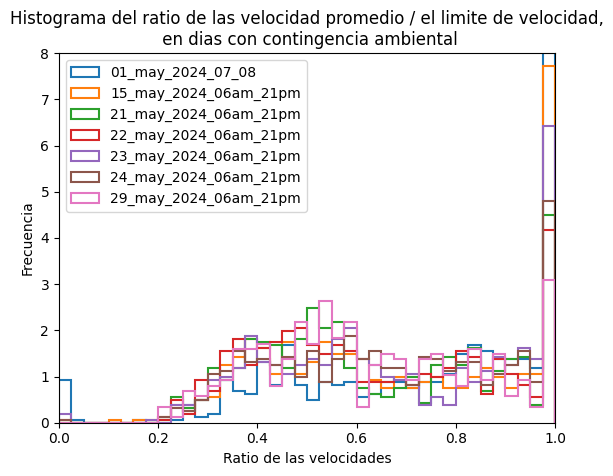

In [105]:
dir = r"C:\Users\Valeria\Documents\CIC\TomTom\Datos\jsons files"
dict_dates = {
	"car_restriction":{
		"jobs_5817876_results_MER_15_may_2024_06am_21pm.json",
		"jobs_5852052_results_MER_23_may_2024_06am_21pm.json",
		"jobs_5852076_results_MER_24_may_2024_06am_21pm.json"
	},
	"normal_day":{
		"jobs_5851993_results_MER_21_may_2024_06am_21pm.json",
		"jobs_5852017_results_MER_22_may_2024_06am_21pm.json",
		"jobs_5853059_results_MER_29_may_2024_06am_21pm.json" } #SMALL_section
	
}
df_yes_cont = []
df_no_cont = []
binsH = 40
files = os.listdir(dir)
for file in files:
	path = os.path.join(dir, file)
	with open(path) as f:
		json_file = json.load(f)
	print(file)
	data = json_file['network']['segmentResults']
	df = pd.DataFrame(data)
	df= df.join(pd.json_normalize(df['segmentTimeResults'].explode()))
	df.drop(columns=['segmentTimeResults'], inplace=True)
	df["traffic_flow"] = df["averageSpeed"] / df["speedLimit"]
	df["traffic_flow_<1"] = df["averageSpeed"] / df["speedLimit"]
	df.loc[df["traffic_flow_<1"] > 1, "traffic_flow_<1"] = 1
	df["date"] = file[25:-5]
	if file in dict_dates["normal_day"]:
		df["contingency"] = "no"
		df_no_cont.append(df)

	if file in dict_dates["car_restriction"]:
		df["contingency"] = "yes"
		df_yes_cont.append(df)

	# Crear el histograma de la columna 'edad'
	#df['averageSpeed'].hist(bins=5, edgecolor='black', )
	plt.hist(df["traffic_flow_<1"], binsH, range=[0, 1], density=True, label=file[25:-5], linewidth=1.5, linestyle = '-', histtype='step')
	#plt.hist(df["averageTravelTime"], binsH, range=[0, 70], density=True, label=file[25:-5], linewidth=1.5, linestyle = '-', histtype='step')

# Personalizar el gráfico
plt.xlabel("Ratio de las velocidades")
plt.ylabel("Frecuencia")
plt.title("Histograma del ratio de las velocidad promedio / el limite de velocidad,\n en dias con contingencia ambiental")
#plt.title("Histograma del promedio de los tiempos de viaje,\n en dias normales")
plt.legend()
plt.axis([0, 1, 0, 8])
# Mostrar el gráfico
plt.show()

In [112]:
concat_df = pd.concat([df_yes_cont[0], df_yes_cont[1], df_yes_cont[2],df_no_cont[0], df_no_cont[1], df_no_cont[2]], ignore_index=True)

yes_cont = pd.concat([df_yes_cont[0], df_yes_cont[1], df_yes_cont[2]], ignore_index=True)
no_cont = pd.concat([df_no_cont[0], df_no_cont[1], df_no_cont[2]], ignore_index=True)


In [110]:
concat_df["contingencyFRC"] = concat_df["contingency"] +concat_df["frc"].astype(str)

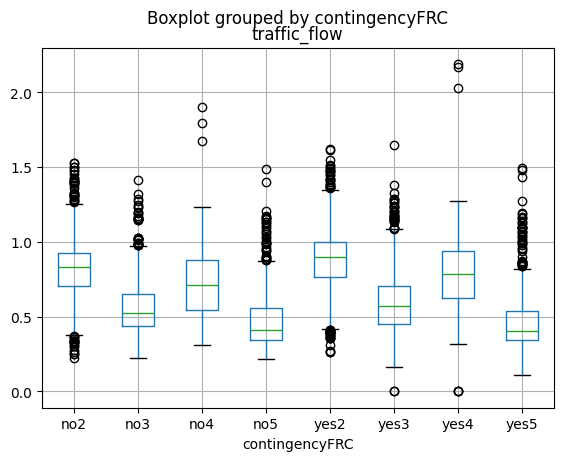

In [111]:
concat_df.boxplot(by="contingencyFRC", column="traffic_flow")
plt.show()

In [104]:
concat_df["contingencyFRC"].unique()

array(['no4', 'no2', 'no3', 'no5', 'yes4', 'yes2', 'yes3', 'yes5'],
      dtype=object)

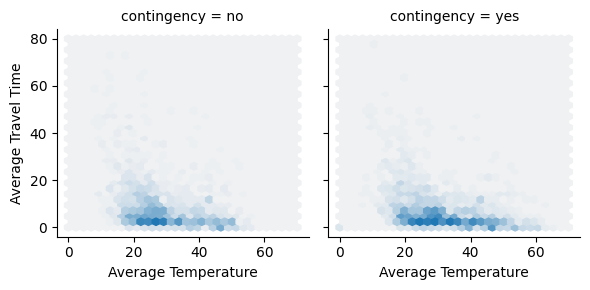

In [ ]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=30, cmap=cmap, **kwargs)
    
g = sns.FacetGrid(concat_df, col='contingency', col_wrap=2)
g.map(hexbin, 'averageSpeed', 'averageTravelTime',
      extent=[0, 70, 0, 80])
g.set_axis_labels('Average Temperature', 'Average Travel Time')

plt.show()

f_value= 22.678 pvalue=  1.992e-06
3.844
We reject H0 because f-statistic 22.678 > f-critical 3.844 and p-value 1.992e-06 < alpha 0.05 
There is significant difference between the sample mean and the hypothesized population mean. 
We have significant evidence at 0.05 level the averageTravelTime belong to different populations.


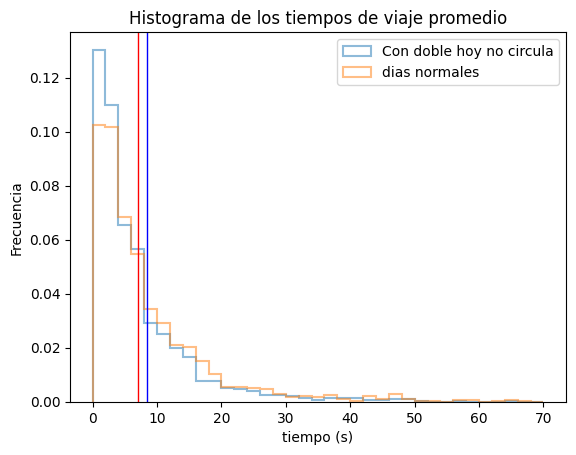

In [ ]:
# Performing the t-test
variable = 'averageTravelTime' 
alpha = 0.05
mean_Ne = yes_cont[variable].mean() 
mean_Be = no_cont[variable].mean() 
# Plotting the data
#plt.hist(yes_cont[variable], alpha=0.5, label='Con doble hoy no circula')
binsH = 35
plt.hist(yes_cont[variable], binsH, range=[0, 70], density=True, linewidth=1.5, linestyle = '-', histtype='step', alpha=0.5, label='con restricción vehicular', )
plt.hist(no_cont[variable], binsH, range=[0, 70], density=True,  linewidth=1.5, linestyle = '-', histtype='step', alpha=0.5, label='dias normales', )
#plt.hist(no_cont[variable], alpha=0.5, label='dia normal')
plt.axvline(mean_Ne, color='r', linestyle='-', linewidth=1)
plt.axvline(mean_Be, color='b', linestyle='-', linewidth=1)
plt.legend(loc='upper right')
plt.xlabel("tiempo (s)")
plt.ylabel("Frecuencia")
plt.title("Histograma de los tiempos de viaje promedio")


fvalue, pvalue = stats.f_oneway(yes_cont[variable], no_cont[variable])
fvalue = fvalue.round(3)
pvalue = pvalue.round(9)
print("f_value=", fvalue, "pvalue= ",pvalue)

df1 = 2-1
df2 = len(yes_cont[variable]) + len(no_cont[variable]) - 2
f_crit = f.ppf(1-alpha,df1, df2).round(3)
print(f_crit)

#Reject the null Hypothesis 
if (fvalue > f_crit) & (pvalue < alpha):
    print(f"We reject H0 because f-statistic {fvalue} > f-critical {f_crit} and p-value {pvalue} < alpha {alpha}",
          f"\nThere is significant difference between the sample mean and the hypothesized population mean.",
		  f"\nWe have significant evidence at 0.05 level the {variable} belong to different populations.")